# DQN trade

In this notebook a fully connected DQN model is trained on the crude oil daily dataset, enriched with the various tecnical indicators and the crude oil implied volatility index `OVX`.

The importance of **implied volatility** for market participants stems from the fact that it is one of the only data that is **forward-looking**. This is because market participants always trade contracts with an expiration date later in time. 

The goal of this notebook is to see how (if it is possible) a A2C trading agent can leverage this kind of data to learn a profitable trading strategy.

In [2]:
#@title **Install externals libraries** {display-mode:'form'}
!pip install stable-baselines3[extra] quantstats --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 35.7 MB/s 
     |████████████████████████████████| 41 kB 14.9 MB/s 
     |████████████████████████████████| 6.4 MB 57.9 MB/s 
     |████████████████████████████████| 62 kB 46.1 MB/s 
     |████████████████████████████████| 1.5 MB 79.5 MB/s 
     |████████████████████████████████| 1.6 MB 60.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=77c4884e1cddb0363716fb81494fe12078a98d32514c5628d7ec98f20312af2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-46wqeqm6/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=fcfbd03a74b5b2be4bc34630d3f3ba

In [3]:
#@title **Imports** {display-mode: 'form'}

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import pandas as pd
import quantstats as qs

from sklearn.preprocessing import StandardScaler

from enum import Enum
import matplotlib.pyplot as plt

from stable_baselines3 import DQN

# Preprocessing

The preprocessing phase consist in the following phases:

- addition of cyclical features for the time-related variables
- standardization of the data

In [6]:
def add_cyclical_features(df):
    df['date'] = pd.to_datetime(df.index.copy(), format='%Y-%m-%d')
    df['day_sin'] = df['date'].apply(lambda x: np.sin(x.day * (2. * np.pi / 30)))
    df['day_cos'] = df['date'].apply(lambda x: np.cos(x.day * (2. * np.pi / 30)))
    df['month_sin'] = df['date'].apply(lambda x: np.sin(x.month * (2. * np.pi / 12)))
    df['month_cos'] = df['date'].apply(lambda x: np.cos(x.month * (2. * np.pi / 12)))
    df = df.drop('date', axis=1)
    return df

In [7]:
cl_df = pd.read_csv('/content/mydrive/MyDrive/Datasets/trading/CL_daily_adj.csv', parse_dates=True)
cl_df = cl_df.set_index('Date')
cl_df = add_cyclical_features(cl_df)
cl_df = cl_df.sort_index()

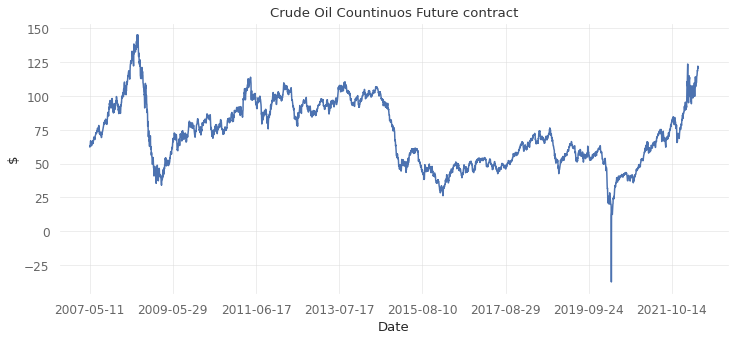

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
cl_df.close.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('$')
ax.set_title('Crude Oil Countinuos Future contract')
plt.show()

In [9]:
sc = StandardScaler()
cols, cl_index = cl_df.columns, cl_df.index
cl_df = pd.DataFrame(sc.fit_transform(cl_df), columns=cols, index=cl_index)
window_size = 21
training_portion = 0.8
episodes = 1000

train_cl_df = cl_df[0:int(np.floor(len(cl_df) * training_portion))]
test_cl_df = cl_df[int(np.floor(len(cl_df) * training_portion)):]

env = FuturesEnv(df=train_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(train_cl_df)))

# Training

Only 80% of the total data is used during the training phase. That's because we want to avoid the model simply memorizing the dataset (overfitting) and obtaining a model that is generalized well in all market situations.

The A2C model is a fully connected neural network with 4 layers with 256, 128, 128, 64 neurson respectvely, the neural network will be given as input the daily data of the previous month (21 days).

In [10]:
policy_kwargs = {'net_arch':[256, 128, 128, 64]}
model = DQN("MlpPolicy", 
            env, 
            verbose=1,
            seed=0,
            train_freq=5,
            exploration_final_eps=0.1,
            exploration_fraction=0.5,
            policy_kwargs=policy_kwargs
            )
model.learn(total_timesteps=episodes*len(train_cl_df))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | -6.32    |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3393     |
|    time_elapsed     | 3        |
|    total_timesteps  | 11624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | -6.48    |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3497     |
|    time_elapsed     | 6        |
|    total_timesteps  | 23248    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 7.5   

# Testing Results

Now that the model has been trained, let's test its performance on the testing data (out of sample data).

In [11]:
testing_env = FuturesEnv(df=test_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(test_cl_df)))

In [12]:
account_history = []
obs = testing_env.reset()
i = 0

while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = testing_env.step(action)

    print(f'step: {i}, reward: {rewards}, account_value: {testing_env.get_account_value()}, action: {action}, position: {info["position"]}')
    account_history.append(testing_env.get_account_value())

    if dones:
      break

    i += 1

step: 0, reward: 0, account_value: 1000000, action: 0, position: 0
step: 1, reward: 0, account_value: 1000000, action: 2, position: 1
step: 2, reward: 0.14360088213104222, account_value: 1000000, action: 0, position: 1
step: 3, reward: 0.19934636314298462, account_value: 1000000, action: 0, position: 1
step: 4, reward: 0.2834899245584901, account_value: 1000000, action: 2, position: 1
step: 5, reward: 0.26310844379173853, account_value: 1000000, action: 2, position: 1
step: 6, reward: 0.23485518022406926, account_value: 1000000, action: 2, position: 1
step: 7, reward: 0.19999163319501412, account_value: 1000000, action: 2, position: 1
step: 8, reward: 0.25581463743638927, account_value: 1000000, action: 2, position: 1
step: 9, reward: 0.24723740851071058, account_value: 1000000, action: 2, position: 1
step: 10, reward: 0.23610032525550492, account_value: 1000000, action: 2, position: 1
step: 11, reward: 0.19352011894457313, account_value: 1000000, action: 2, position: 1
step: 12, rewar

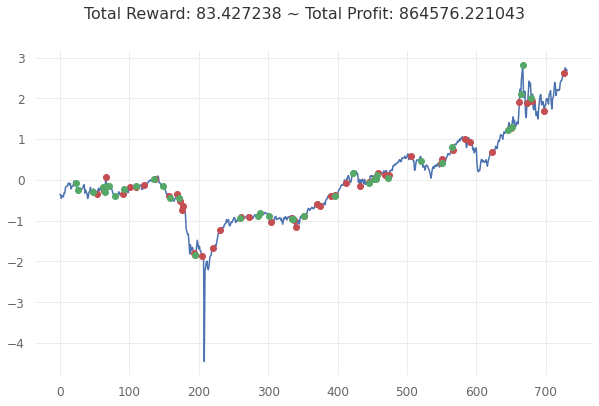

In [13]:
plt.cla()
testing_env.render_all()

## Testing period statistics

Let's see how the trading strategy learned in the training phase has performed on data that the model has never seen before. 

[Performance Metrics]



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


                           Strategy
-------------------------  ----------
Start Period               2019-07-15
End Period                 2022-06-13
Risk-Free Rate             0.0%
Time in Market             6.0%

Cumulative Return          -13.54%
CAGR﹪                     -4.87%

Sharpe                     -0.8
Prob. Sharpe Ratio         11.41%
Smart Sharpe               -0.8
Sortino                    -1.11
Smart Sortino              -1.1
Sortino/√2                 -0.78
Smart Sortino/√2           -0.78
Omega                      0.5

Max Drawdown               -17.08%
Longest DD Days            706
Volatility (ann.)          6.23%
Calmar                     -0.29
Skew                       3.06
Kurtosis                   127.11

Expected Daily %           -0.02%
Expected Monthly %         -0.4%
Expected Yearly %          -3.57%
Kelly Criterion            -31.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.67%
Expected Shortfall (cVaR)  -0.67%

Max Consecutive Win

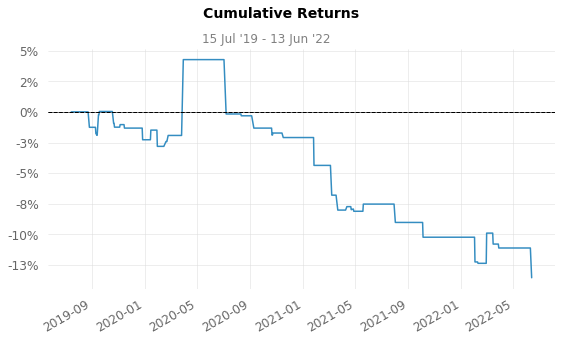

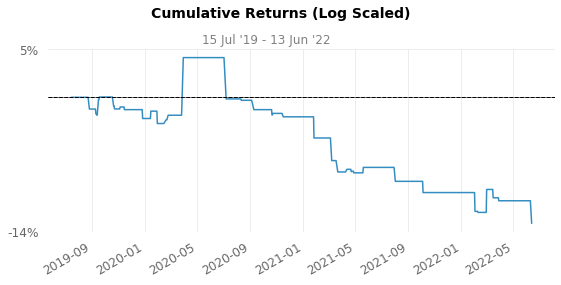

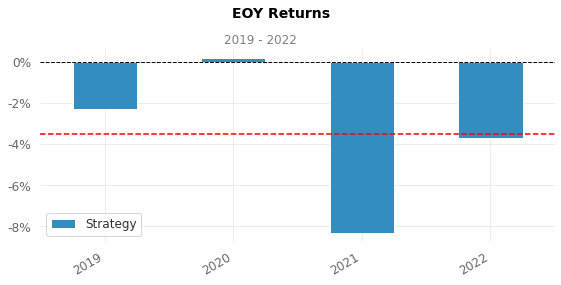

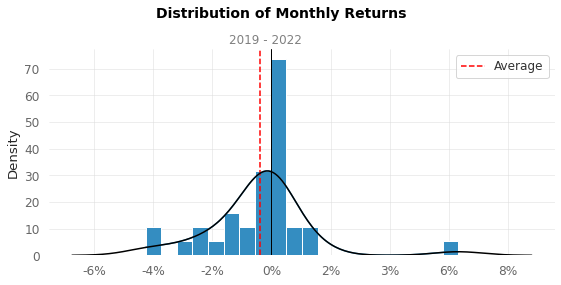

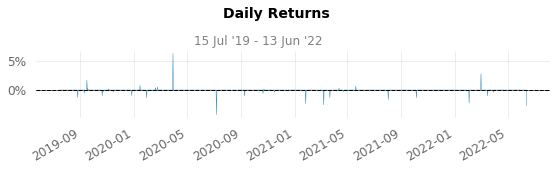

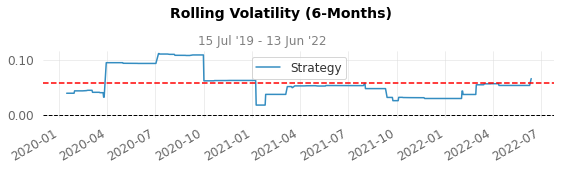

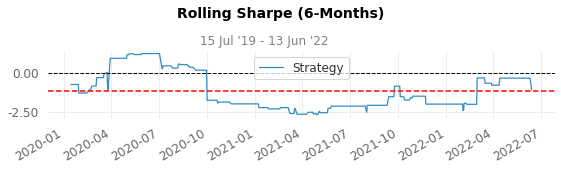

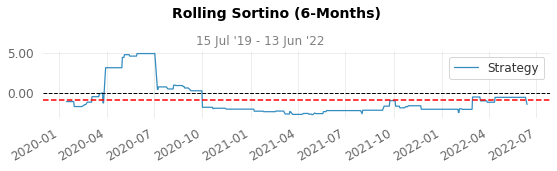

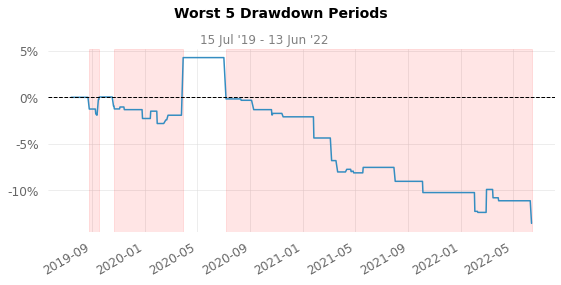

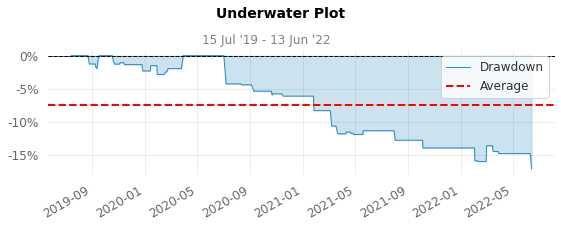

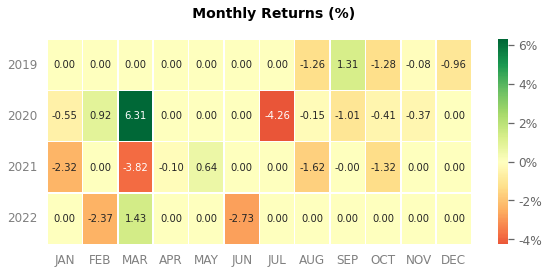

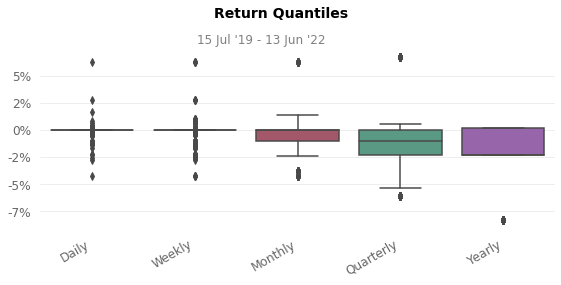

In [14]:
qs.extend_pandas()

net_worth = pd.Series(testing_env.history['total_profit'], index=test_cl_df.index[22:])
net_worth.index = pd.to_datetime(net_worth.index)

returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns, match_dates=True)